In [1]:
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kagglehub
from kagglehub import KaggleDatasetAdapter
import tensorflow as tf
from tensorflow.keras import layers, models, Input


In [2]:
# Paso 1: Fuente de datos desde GitHub o Kaggle
USE_KAGGLE = False  # Cambiar a True si deseas usar la fuente desde Kaggle

if USE_KAGGLE:
    # Fuente alternativa desde Kaggle
    !pip install -q kagglehub[pandas-datasets]


    dataset_path ="/kaggle/input/webots-car-navigation"

    dataset_path = kagglehub.dataset_download(
        "paradajoseluis/webots-car-navigation",
        "1.0" # Specify a version if needed, otherwise remove
    )

    file_path = os.path.join(dataset_path, "steering_angles.csv")  # Construct the path to the CSV within the downloaded dataset
    import pandas as pd # Make sure pandas is imported
    df = pd.read_csv(file_path)

    IMAGE_FOLDER = os.path.join(dataset_path, "DATASET", "DATASET") # Adjust based on the actual downloaded structure if needed

    print(f"Dataset downloaded to: {dataset_path}")
    print(f"CSV file path: {file_path}")
    print(f"Image folder path: {IMAGE_FOLDER}")

else:
    # Clonar dataset desde GitHub
    !git clone https://github.com/edwinhdez/navegacion_autonoma_proyecto_final.git  # Reemplaza con el link real

    # Ruta al archivo CSV y carpeta de imágenes
    CSV_PATH = "navegacion_autonoma_proyecto_final/dataset/steering_angles_intersection.csv"
    IMAGE_FOLDER = "/content/navegacion_autonoma_proyecto_final/dataset/DATASET"

    # Cargar el archivo CSV

    df = pd.read_csv(CSV_PATH)

Cloning into 'navegacion_autonoma_proyecto_final'...
remote: Enumerating objects: 30048, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 30048 (delta 1), reused 4 (delta 1), pack-reused 30043 (from 3)
Receiving objects: 100% (30048/30048), 1.72 GiB | 17.60 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (30034/30034), done.


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun 19 21:40:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   45C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Renombrar columnas para consistencia
df = df.rename(columns={
    'image_name': 'center',
    'steering_angle': 'steering',
    'INTERSECTION': 'intersection'
})

In [5]:
df['intersection'] = df['intersection'].astype(int)

In [6]:
# Parámetros de imagen
IMG_HEIGHT, IMG_WIDTH = 66, 200

def preprocess_image(img_name):
    """
    Preprocesa una imagen para el modelo de navegación autónoma.

    Parámetros:
        img_name (str): Nombre del archivo de la imagen a procesar.

    Proceso:
        - Construye la ruta completa de la imagen usando IMAGE_FOLDER.
        - Lee la imagen desde disco.
        - Lanza un error si la imagen no se puede leer.
        - Convierte la imagen de BGR a RGB.
        - Redimensiona la imagen a (IMG_WIDTH, IMG_HEIGHT).
        - Normaliza los valores de los pixeles a rango [0, 1].

    Retorna:
        np.ndarray: Imagen preprocesada lista para ser usada por el modelo.
    """
    path = os.path.join(IMAGE_FOLDER, img_name)
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"No se pudo leer la imagen: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0
    return img

In [7]:
def augment_image(image, angle):
    """
    Realiza aumentos de datos en la imagen y ajusta el ángulo de giro correspondiente.

    Parámetros:
        image (np.ndarray): Imagen de entrada en formato RGB y valores en [0, 1].
        angle (float): Ángulo de giro original.

    Proceso:
        - Con probabilidad 0.5, voltea horizontalmente la imagen y cambia el signo del ángulo.
        - Modifica el brillo de la imagen en el espacio HSV de forma aleatoria.
        - Convierte la imagen de nuevo a RGB y normaliza a [0, 1].

    Retorna:
        tuple: (imagen aumentada, ángulo ajustado)
    """
    import random
    if random.random() < 0.5:
        image = cv2.flip(image, 1)
        angle = -angle
    hsv = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    hsv[:, :, 2] = hsv[:, :, 2] * (0.3 + np.random.uniform())
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB) / 255.0
    return image, angle

In [8]:
def load_data(df):
    """
    Carga y preprocesa todas las imágenes y etiquetas desde el DataFrame.

    Parámetros:
        df (pd.DataFrame): DataFrame con las columnas 'center', 'steering' e 'intersection'.

    Proceso:
        - Itera sobre cada fila del DataFrame.
        - Preprocesa la imagen correspondiente usando preprocess_image.
        - Almacena la imagen, el ángulo de giro y la etiqueta de intersección en listas.

    Retorna:
        tuple: (np.ndarray de imágenes, np.ndarray de ángulos, np.ndarray de intersecciones)
    """
    images, angles, dirs, ints = [], [], [], []
    for _, row in df.iterrows():
        img = preprocess_image(row['center'])
        images.append(img)
        angles.append(row['steering'])
        ints.append(row['intersection'])
    return np.array(images), np.array(angles), np.array(ints)

In [9]:
import os
IMAGE_FOLDER = "/content/navegacion_autonoma_proyecto_final/dataset/DATASET"
print(os.listdir(IMAGE_FOLDER))  #Verificamos acceso a las imagenes

['7861.jpg', '19838.jpg', '2929.jpg', '15842.jpg', '21349.jpg', '6092.jpg', '16522.jpg', '28930.jpg', '5167.jpg', '25076.jpg', '8135.jpg', '1229.jpg', '7086.jpg', '723.jpg', '17545.jpg', '4124.jpg', '5782.jpg', '28420.jpg', '24040.jpg', '22073.jpg', '13764.jpg', '1271.jpg', '17973.jpg', '18722.jpg', '12764.jpg', '29362.jpg', '8798.jpg', '25850.jpg', '23652.jpg', '11837.jpg', '5392.jpg', '19926.jpg', '10792.jpg', '21569.jpg', '18580.jpg', '22284.jpg', '16185.jpg', '8883.jpg', '15563.jpg', '15402.jpg', '913.jpg', '17537.jpg', '26939.jpg', '823.jpg', '26186.jpg', '18812.jpg', '22918.jpg', '25299.jpg', '8284.jpg', '29046.jpg', '20348.jpg', '20531.jpg', '24166.jpg', '1671.jpg', '20335.jpg', '13846.jpg', '9384.jpg', '22082.jpg', '10227.jpg', '16794.jpg', '9180.jpg', '23377.jpg', '10367.jpg', '2059.jpg', '14831.jpg', '13354.jpg', '6534.jpg', '887.jpg', '27771.jpg', '16934.jpg', '6034.jpg', '22638.jpg', '28540.jpg', '10362.jpg', '4688.jpg', '9797.jpg', '5117.jpg', '20598.jpg', '16076.jpg', '24

In [10]:
# Carga y preprocesa todas las imágenes y etiquetas desde el DataFrame, retornando imágenes, ángulos y etiquetas de intersección
X, y_angle, y_inter = load_data(df)

In [11]:
# Divide los datos en conjuntos de entrenamiento, validación y prueba.
# Primero, separa el 10% de los datos para el conjunto de prueba (test).
X_temp, X_test, y_angle_temp, y_angle_test, y_inter_temp, y_inter_test = train_test_split(
    X, y_angle, y_inter, test_size=0.1, random_state=42)  # 10% para test

# Luego, del 90% restante, separa el 20% para validación (val) y el 80% para entrenamiento (train).
X_train, X_val, y_angle_train, y_angle_val, y_inter_train, y_inter_val = train_test_split(
    X_temp, y_angle_temp, y_inter_temp, test_size=0.2, random_state=42)  # 20% del 90% restante para validación

In [12]:
# Modelo multitarea NVIDIA
import tensorflow as tf
from tensorflow.keras import layers, models, Input

In [13]:
def build_multitask_model():
    """
    Construye y compila un modelo multitarea basado en la arquitectura NVIDIA para conducción autónoma.
    El modelo tiene dos salidas:
        - intersection: predicción binaria (intersección o no)
        - angle: regresión del ángulo de giro
    Utiliza varias capas convolucionales y densas para extraer características de las imágenes.
    """
    inputs = Input(shape=(66, 200, 3))  # Entrada: imagen RGB de 66x200 píxeles

    # Primera capa convolucional: 24 filtros 5x5, stride 2, activación ReLU
    x = layers.Conv2D(24, (5, 5), strides=(2, 2), activation='relu')(inputs)
    # Segunda capa convolucional: 36 filtros 5x5, stride 2, activación ReLU
    x = layers.Conv2D(36, (5, 5), strides=(2, 2), activation='relu')(x)
    # Tercera capa convolucional: 48 filtros 5x5, stride 2, activación ReLU
    x = layers.Conv2D(48, (5, 5), strides=(2, 2), activation='relu')(x)
    # Cuarta capa convolucional: 64 filtros 3x3, activación ReLU
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    # Quinta capa convolucional: 64 filtros 3x3, activación ReLU
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    # Aplanar la salida para conectarla a las capas densas
    x = layers.Flatten()(x)
    # Capa densa de 100 neuronas, activación ReLU
    x = layers.Dense(100, activation='relu')(x)
    # Capa densa de 50 neuronas, activación ReLU
    x = layers.Dense(50, activation='relu')(x)
    # Capa densa de 10 neuronas, activación ReLU
    x = layers.Dense(10, activation='relu')(x)

    # Salida 1: predicción de intersección (binaria, activación sigmoide)
    inter_out = layers.Dense(1, activation='sigmoid', name='intersection')(x)
    # Salida 2: predicción de ángulo (regresión, activación lineal)
    angle_out = layers.Dense(1, activation='linear', name='angle')(x)

    # Definir el modelo con dos salidas
    model = models.Model(inputs=inputs, outputs=[inter_out, angle_out])

    # Compilar el modelo con optimizador Adam, pérdidas y métricas para cada salida
    model.compile(
        optimizer='adam',  # Optimizador Adam
        loss={
            'intersection': 'binary_crossentropy',  # Pérdida binaria para intersección
            'angle': 'mse'                          # Error cuadrático medio para ángulo
        },
        metrics={
            'intersection': 'accuracy',             # Métrica de exactitud para intersección
            'angle': 'mae'                          # Error absoluto medio para ángulo
        }
    )

    return model  # Devuelve el modelo compilado

In [14]:
# Construye el modelo multitarea y muestra un resumen de su arquitectura
model = build_multitask_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 66, 200,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 31, 98,    │      1,824 │ input_layer[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 47,    │     21,636 │ conv2d[0][0]      │
│                     │ 36)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 5, 22, 48) │     43,248 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 3, 20, 64) │     27,712 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1, 18, 64) │     36,928 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1152)      │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100)       │    115,300 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50)        │      5,050 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10)        │        510 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ intersection        │ (None, 1)         │         11 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ angle (Dense)       │ (None, 1)         │         11 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 252,230 (985.27 KB)

 Trainable params: 252,230 (985.27 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Crear callback para checkpoints para guardar automáticamente el mejor modelo durante el entrenamiento
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_cb = ModelCheckpoint(
    "checkpoint_best.h5",           # Nombre del archivo a guardar
    save_best_only=True,            # Solo guarda si mejora la métrica de validación
    monitor="val_loss",             # Monitorea la pérdida total de validación
    mode="min",                     # Busca el mínimo de la pérdida
    save_weights_only=False,        # Guarda el modelo completo
    verbose=1
)

In [16]:
# Entrenamiento del modelo multitarea
history = model.fit(
    X_train,  # Imágenes de entrenamiento
    {
        'intersection': y_inter_train,  # Etiquetas de intersección para entrenamiento
        'angle': y_angle_train          # Etiquetas de ángulo para entrenamiento
    },
    validation_data=(X_val, {           # Datos de validación
        'intersection': y_inter_val,    # Etiquetas de intersección para validación
        'angle': y_angle_val            # Etiquetas de ángulo para validación
    }),
    epochs=10,                          # Número de épocas de entrenamiento
    batch_size=32                       # Tamaño del batch
)

Epoch 1/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - angle_loss: 0.0062 - angle_mae: 0.0458 - intersection_accuracy: 0.9719 - intersection_loss: 0.0808 - loss: 0.0870 - val_angle_loss: 4.3496e-04 - val_angle_mae: 0.0146 - val_intersection_accuracy: 0.9963 - val_intersection_loss: 0.0123 - val_loss: 0.0127
Epoch 2/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - angle_loss: 8.0051e-04 - angle_mae: 0.0192 - intersection_accuracy: 0.9954 - intersection_loss: 0.0127 - loss: 0.0135 - val_angle_loss: 8.6720e-04 - val_angle_mae: 0.0262 - val_intersection_accuracy: 0.9980 - val_intersection_loss: 0.0095 - val_loss: 0.0104
Epoch 3/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - angle_loss: 6.1245e-04 - angle_mae: 0.0172 - intersection_accuracy: 0.9952 - intersection_loss: 0.0128 - loss: 0.0134 - val_angle_loss: 2.9589e-04 - val_angle_mae: 0.0124 - val_intersection_accuracy: 0.9967 - val_intersection_loss: 0.0103 - val_loss: 0.0106
Epoch 4/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - angle_loss: 

In [17]:
def graficar_accuracy_entrenamiento(history):
    """
    Grafica el accuracy de la tarea de intersección durante el entrenamiento y validación.

    Parámetros:
        history: objeto History devuelto por model.fit()
    """
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['intersection_accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_intersection_accuracy'], label='Validación')
    plt.title('Accuracy de Intersección durante el entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

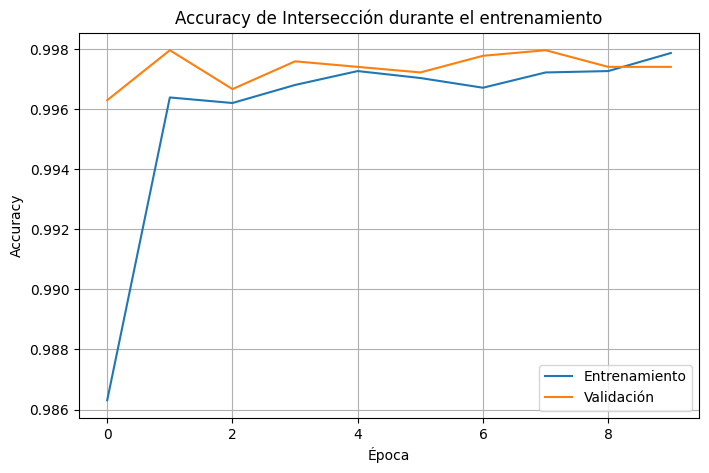

In [18]:
# Graficar la evolución del accuracy de intersección
graficar_accuracy_entrenamiento(history)

In [19]:
# Evaluación del modelo en el conjunto de prueba
print("Evaluación en el conjunto de prueba:")
model.evaluate(
    X_test,  # Imágenes de prueba
    {
        'intersection': y_inter_test,  # Etiquetas de intersección para prueba
        'angle': y_angle_test          # Etiquetas de ángulo para prueba
    }
)

Evaluación en el conjunto de prueba:
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - angle_loss: 4.5517e-04 - angle_mae: 0.0152 - intersection_accuracy: 0.9960 - intersection_loss: 0.0149 - loss: 0.0153


[0.013849089853465557,
 0.013423432596027851,
 0.0004033970180898905,
 0.01466047391295433,
 0.9966700077056885]

loss: 0.0100

Es la pérdida total combinada del modelo (suma ponderada de las pérdidas de ambas salidas).
intersection_loss: 0.00976

Pérdida (binary crossentropy) para la tarea de intersección.
angle_loss: 0.00025

Pérdida (MSE) para la tarea de ángulo.
intersection_accuracy: 0.00989

Exactitud para la tarea de intersección (debería estar cerca de 1 si el modelo es bueno).
angle_mae: 0.9970

Error absoluto medio para la tarea de ángulo (mientras más bajo, mejor).

Resumen de tus resultados
El modelo predice intersecciones con una exactitud muy alta (~99.7%).
El error absoluto medio del ángulo es bajo (0.0106), lo que indica buena precisión en la regresión del ángulo.
Las pérdidas son bajas, lo que sugiere que el modelo está funcionando bien en ambos objetivos.

In [20]:
# Guardar modelo
model.save("nvidia_multitask_model.h5")

In [21]:
import random
import matplotlib.pyplot as plt

def mostrar_predicciones(model, X_test, y_inter_test, y_angle_test, num_imagenes=10):
    """
    Muestra imágenes aleatorias del set de prueba junto con sus predicciones y valores reales.

    Parámetros:
        model: modelo entrenado.
        X_test: imágenes de prueba.
        y_inter_test: etiquetas reales de intersección.
        y_angle_test: etiquetas reales de ángulo.
        num_imagenes: número de imágenes a mostrar.
    """
    for i in range(num_imagenes):
        idx = random.randint(0, len(X_test) - 1)
        img = X_test[idx]
        real_inter = y_inter_test[idx]
        real_angle = y_angle_test[idx]

        # Hacemos la predicción (agregando un batch dimension)
        pred_inter, pred_angle = model.predict(img[np.newaxis, ...], verbose=0)

        plt.figure(figsize=(4, 3))
        plt.imshow(img)
        plt.title(
            f"Real: Intersección={real_inter}, Ángulo={real_angle:.2f}\n"
            f"Predicho: Intersección={pred_inter[0][0]:.2f}, Ángulo={pred_angle[0][0]:.2f}"
        )
        plt.axis('off')
        plt.show()

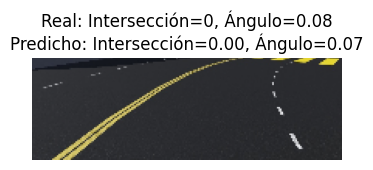

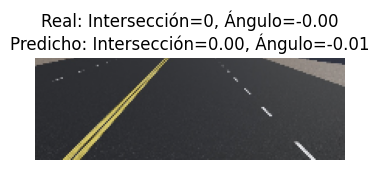

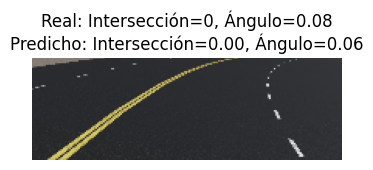

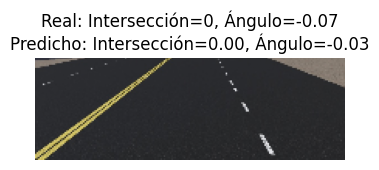

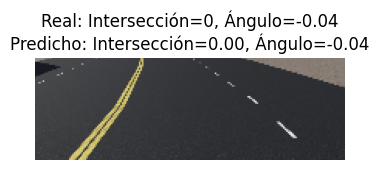

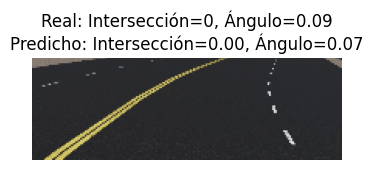

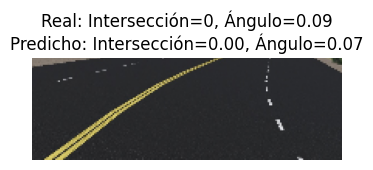

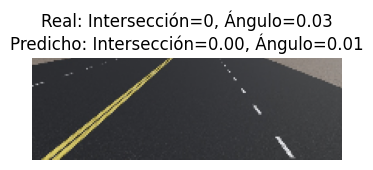

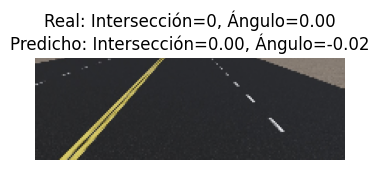

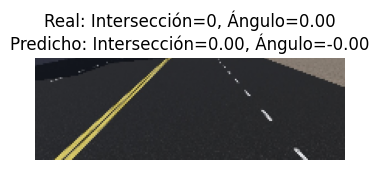

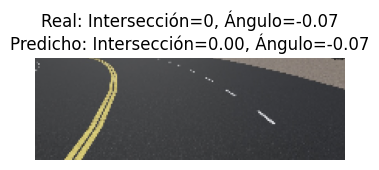

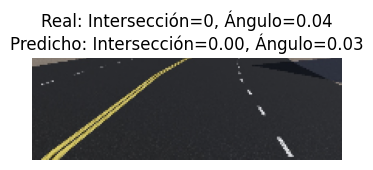

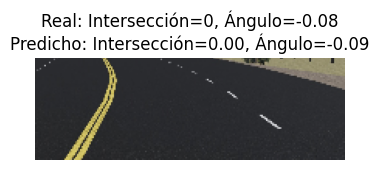

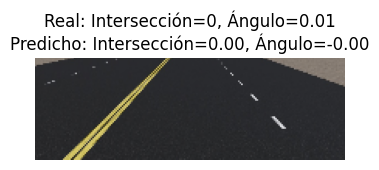

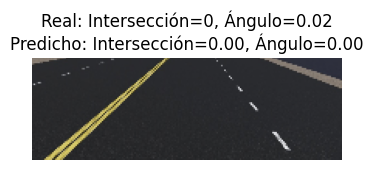

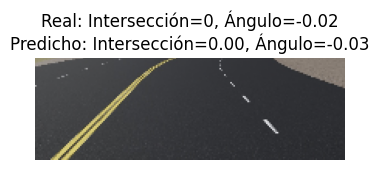

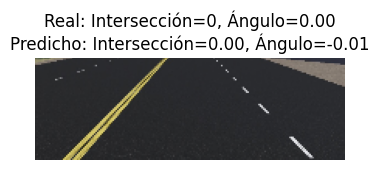

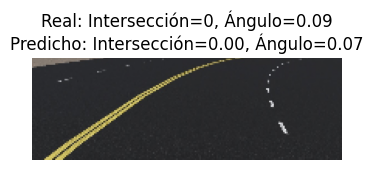

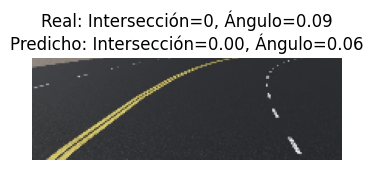

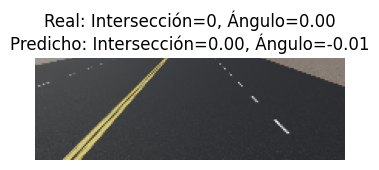

In [22]:
mostrar_predicciones(model, X_test, y_inter_test, y_angle_test, num_imagenes=20)